<a href="https://colab.research.google.com/github/anhle/Kaggle/blob/master/House_Prices_Advanced_Regression_Techniques/House_Prices_Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predciting Ames house prices

## Project Overview
Predicting the residential house price can guide real estate agents during the decision making and
pricing process, therefore assistant their customers to find the best selling price for their houses.

Industry leaders also use the prediction of the house price for various purposes. Zillow uses the
prediction of the house price to provide guidance to its online seller and buyer. Airbnb leverages
the house price prediction to inform their hosts to better pricing their places.

The objective of this project is to predict the final price of a house given 79 explanatory variables that describe almost all aspects of a house in Ames, Iowa. This project is from a Kaggle
playground competition ( [link](https://www.kaggle.com/c/house-prices-advanced-regressiontechniques))

# Problem Statement
The Ultimate goal of this project is to train a model based on the given data to predict the house
price as accurate as possible evaluated by the Kaggle Leaderboard. The related tasks to this
problem include:

* **Exploratory	data	analysis**	– Understanding	the	type	of	features	in	the	dataset,	how	much	
missing	values	of	different	features,	how	many	outliers	are	existed	and	whether	specific	
features	are	skewed, are	crucial	in	order	to	create	a	good	model	in	the	end.
* **Feature	preprocessing**	– Preprocess	the	data	using	the	insights obtained	from	the	
exploratory	data	analysis,	potentially	including	feature	transformation,	data	type	
transformation,	outlier	detection	and	imputing	missing	values.
* **Benchmark	modeling**	– Creating	a	model	using	a	standard	technique	for	the	problem	in	
order	to	set	up	a	benchmark	for	the	future	modeling	improvement.
* **Model	improvement**	– Tuning	model	parameters	to	improve	the	performance	of	
individual	model	and	stacking	individual	models	to	provide	final	submission	using	
ensemble	learning	technique.



# Metrics
 The Root Mean Squared Logarithmic Error (RMSLE) will be used to as the evaluation metrics
 for this project. The RMSLE can be expressed as:
$
RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}(log(p_i + 1) - log(a_i +1))^2}
$

where 𝜖 is the RMSLE score, n is the total number of observations, 𝑝+ is the predicted number of the house price, 𝑎+ is the associated actual house price and log(𝑥) is the natural logarithm of 𝑥. The value of RMSLE is higher when the differences between the predicted and actual house prices are larger.

Compared to the most common Root Mean Squared Error (RMSE), RMSLE does not heavily penalize the huge difference between the predicted and actual values.



# 1. Data Exploration
The training dataset is mixed with categorical and numerical features as well as some missing values. Specifically, there are 1460 observations, each with 79 features including the sale price of the house. The test dataset has 1461 observations, each with 78 features. 

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [19]:
!pip install catboost
!pip install eli5

In [0]:
from catboost import CatBoostRegressor, Pool, cv

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error as mse

import eli5
from eli5.sklearn import PermutationImportance

import hyperopt

from numpy.random import RandomState
from os import listdir

In [21]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print ("Train data shape:", df_train.shape)
print ("Test data shape:", df_test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [22]:
submission = pd.read_csv("sample_submission.csv", index_col=0)
submission.head()

,SalePrice
Id,
1461,169277.052498
1462,187758.393989
1463,183583.683570
1464,179317.477511
1465,150730.079977


In [0]:
df_combined = df_train.drop("SalePrice", axis=1).append(df_test)

In [24]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We see that test has only 80 columns, while train has 81. This is due to, of course, the fact that the test data do not include the final sale price information!

In [25]:
#check the decoration
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

 ## First things first: analysing 'SalePrice'

In [26]:
#descriptive statistics summary
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

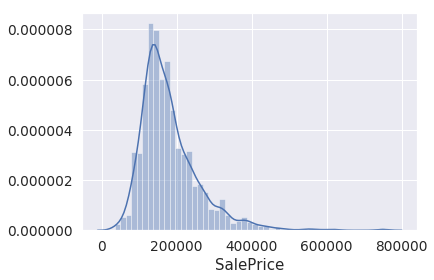

In [27]:
#histogram
sns.distplot(df_train['SalePrice']);

In [28]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## Relationship with numerical variables

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


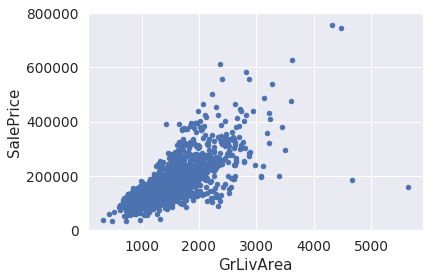

In [29]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

It seems that 'SalePrice' and 'GrLivArea' are really old friends, with a linear relationship.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


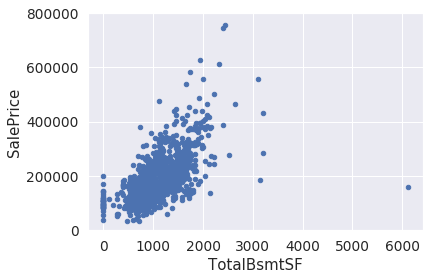

In [30]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

'TotalBsmtSF' is also a great friend of 'SalePrice' but this seems a much more emotional relationship! Everything is ok and suddenly, in a strong linear (exponential?) 

## Relationship with categorical features

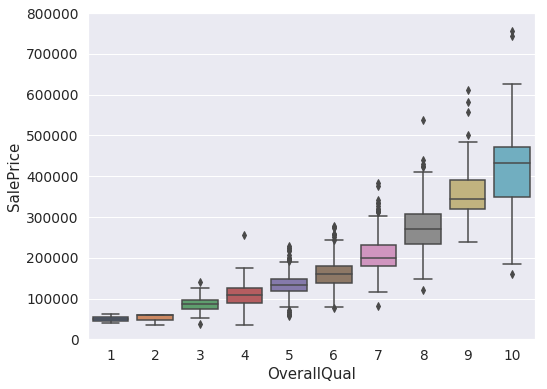

In [31]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

SalePrice' enjoys 'OverallQual'

In summary
Stories aside, we can conclude that:

'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.
We just analysed four variables, but there are many other that we should analyse. The trick here seems to be the choice of the right features (feature selection) and not the definition of complex relationships between them (feature engineering).

That said, let's separate the wheat from the chaff.

## The 'plasma soup'
To explore the universe, we will start with some practical recipes to make sense of our 'plasma soup':

Correlation matrix (heatmap style).
'SalePrice' correlation matrix (zoomed heatmap style).
Scatter plots between the most correlated variables (move like Jagger style).

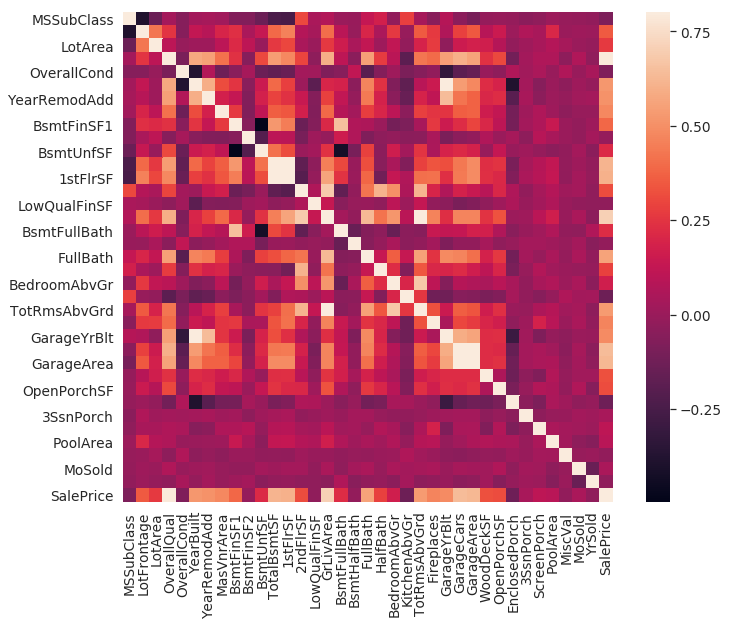

In [32]:
#correlation matrix
#corrmat = df_train.corr()
corrmat = df_train.select_dtypes(include = ['float64','int64']).iloc[:,1:].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

At first sight, there are two red colored squares that get my attention. The first one refers to the 'TotalBsmtSF' and '1stFlrSF' variables, and the second one refers to the 'GarageX' variables. Both cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs. Heatmaps are great to detect this kind of situations and in problems dominated by feature selection, like ours, they are an essential tool.

Another thing that got my attention was the 'SalePrice' correlations. We can see our well-known 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' saying a big 'Hi!', but we can also see many other variables that should be taken into account. That's what we will do next.

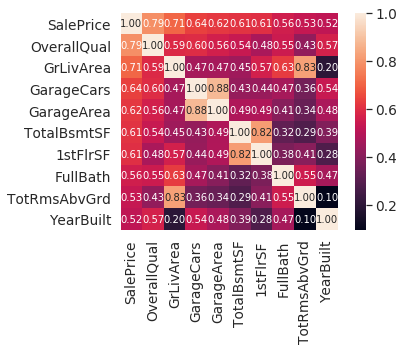

In [33]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

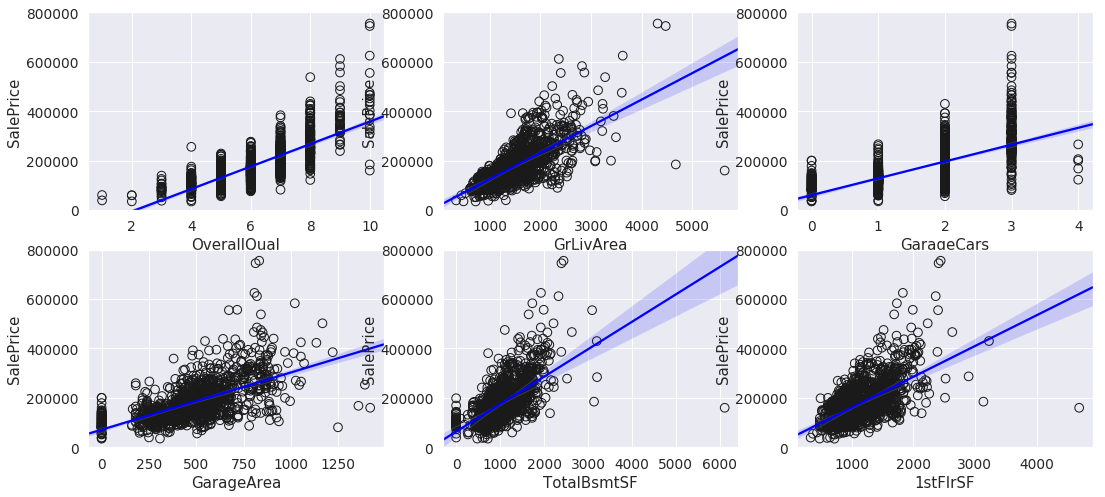

In [34]:
corr_list = corrmat['SalePrice'].sort_values(axis=0,ascending=False).iloc[1:].index
plt.figure(figsize=(18,8))
for i in range(6):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    feature = corr_list.values[i]
    plt.scatter(df_train[feature], df_train['SalePrice'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'SalePrice', data = df_train,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,800000])

According to our crystal ball, these are the variables most correlated with 'SalePrice'. My thoughts on this:

* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. Check!
* 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
*'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF' just to say that our first guess was right (re-read 'So... What can we expect?').
*'FullBath'?? Really?
*'TotRmsAbvGrd' and 'GrLivArea', twin brothers again. Is this dataset from Chernobyl?
Ah... 'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'. Honestly, it scares me to think about 'YearBuilt' because I start feeling that we should do a little bit of time-series analysis to get this right. I'll leave this as a homework for you.

Let's proceed to the scatter plots.

# Missing data
Important questions when thinking about missing data:

How prevalent is the missing data?
Is missing data random or does it have a pattern?
The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

In [35]:
#missing data
total = df_combined.isnull().sum().sort_values(ascending=False)
percent = (df_combined.isnull().sum()/df_combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


Let's analyse this to understand how to handle the missing data.

We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. The point is: will we miss this data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house (maybe that's the reason why data is missing?). Moreover, looking closer at the variables, we could say that variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.

In what concerns the remaining cases, we can see that 'GarageX' variables have the same number of missing data. I bet missing data refers to the same set of observations (although I will not check it; it's just 5% and we should not spend 20 𝑖𝑛5  problems). Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, I'll delete the mentioned 'GarageX' variables. The same logic applies to 'BsmtX' variables.

Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.

Finally, we have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

In [0]:
#dealing with missing data
# df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
# df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
# df_train.isnull().sum().max() #just checking that there's no missing data missing...

In [0]:
#df_train.columns

In [38]:
#dealing with missing data
df_combined = df_combined.drop((missing_data[missing_data['Percent'] > 0.15]).index,1)
df_combined = df_combined.drop(df_combined.loc[df_combined['Electrical'].isnull()].index)
df_combined.isnull().sum().max() #just checking that there's no missing data missing...

159

In [39]:
df_combined.isnull().sum().sort_values(ascending=False)

GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageQual       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtFullBath       2
Exterior2nd        1
Exterior1st        1
KitchenQual        1
TotalBsmtSF        1
GarageCars         1
SaleType           1
GarageArea         1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
YearRemodAdd       0
RoofMatl           0
RoofStyle          0
                ... 
LotArea            0
MSSubClass         0
ExterQual          0
SaleCondition      0
Foundation         0
Heating            0
YrSold             0
MoSold             0
MiscVal            0
PoolArea           0
ScreenPorch        0
3SsnPorch          0
EnclosedPorch      0
OpenPorchSF        0
WoodDeckSF         0
PavedDrive         0
Fireplaces   

In [40]:
df_combined.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'Enclos

# Categorical candidates

In [41]:
cat_candidates = df_combined.dtypes[df_combined.dtypes=="object"].index.values
cat_candidates

array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'], dtype=object)

Feature Importance by level frequencies
Some categorical features might be completely useless as only some levels occur most of the time (no diversity). To get more insights, we can compute the frequency of the most common level in the train & test data:

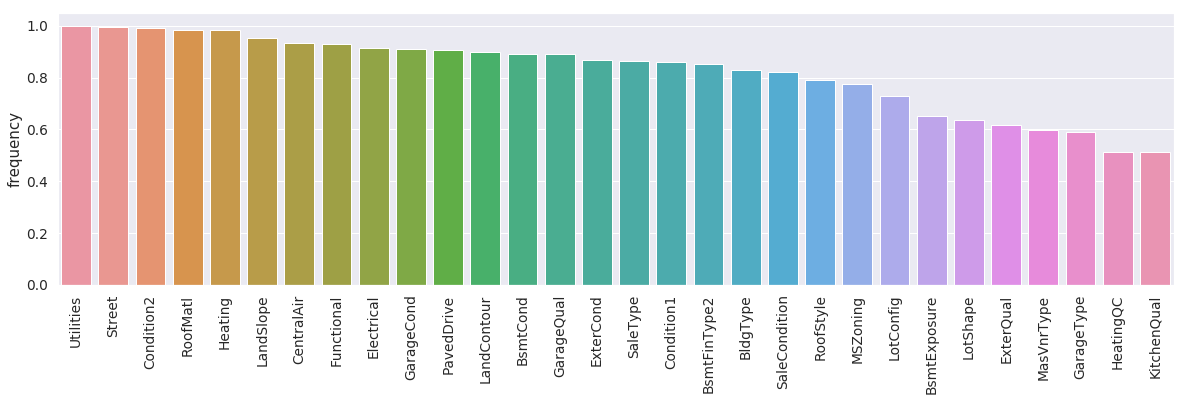

In [42]:
frequencies = []
for col in cat_candidates:
    overall_freq = df_combined.loc[:, col].value_counts().max() / df_combined.shape[0]
    frequencies.append([col, overall_freq])

frequencies = np.array(frequencies)
freq_df = pd.DataFrame(index=frequencies[:,0], data=frequencies[:,1], columns=["frequency"])
sorted_freq = freq_df.frequency.sort_values(ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float))
plt.xticks(rotation=90);

Insights
Many categorical candidates have one major level that occupies > 80 % of the data. That's bad. What should we learn from such a feature? 

This is a completely useless feature! Let's drop all features that show a most common value of 90 %.

In [43]:
freq_df.frequency = freq_df.frequency.astype(np.float)
cats_to_drop = freq_df[freq_df.frequency >= 0.9].index.values
cats_to_drop

array(['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl',
       'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageCond',
       'PavedDrive'], dtype=object)

In [44]:
df_combined = df_combined.drop(cats_to_drop, axis=1)
df_combined.shape

(2917, 63)

# Numerical candidates

In [45]:
num_candidates = df_combined.dtypes[df_combined.dtypes!="object"].index.values
df_combined.loc[:, num_candidates].head(10)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008
1,2,20,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007
2,3,60,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008
3,4,70,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006
4,5,60,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008
5,6,50,14115,5,5,1993,1995,0.0,732.0,0.0,64.0,796.0,796,566,0,1362,1.0,0.0,1,1,1,1,5,0,1993.0,2.0,480.0,40,30,0,320,0,0,700,10,2009
6,7,20,10084,8,5,2004,2005,186.0,1369.0,0.0,317.0,1686.0,1694,0,0,1694,1.0,0.0,2,0,3,1,7,1,2004.0,2.0,636.0,255,57,0,0,0,0,0,8,2007
7,8,60,10382,7,6,1973,1973,240.0,859.0,32.0,216.0,1107.0,1107,983,0,2090,1.0,0.0,2,1,3,1,7,2,1973.0,2.0,484.0,235,204,228,0,0,0,350,11,2009
8,9,50,6120,7,5,1931,1950,0.0,0.0,0.0,952.0,952.0,1022,752,0,1774,0.0,0.0,2,0,2,2,8,2,1931.0,2.0,468.0,90,0,205,0,0,0,0,4,2008
9,10,190,7420,5,6,1939,1950,0.0,851.0,0.0,140.0,991.0,1077,0,0,1077,1.0,0.0,1,0,2,2,5,2,1939.0,1.0,205.0,0,4,0,0,0,0,0,1,2008


Just by looking at the data we can see that there are a lot of features that are not numeric but categorical like OverallQual and OverallCond.

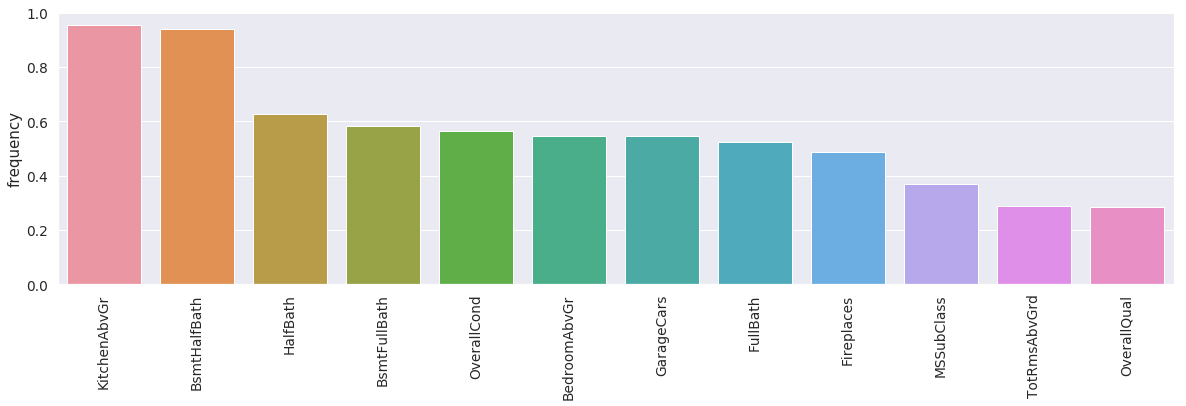

In [46]:
next_cat_candidates = [
    "OverallQual", "OverallCond", "MSSubClass", 'BsmtFullBath',
    'BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'
]

frequencies = []
for col in next_cat_candidates:
    overall_freq = df_combined.loc[:, col].value_counts().max() / df_combined.shape[0]
    frequencies.append([col, overall_freq])

frequencies = np.array(frequencies)
freq_df = pd.DataFrame(index=frequencies[:,0], data=frequencies[:,1], columns=["frequency"])
sorted_freq = freq_df.frequency.sort_values(ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float))
plt.xticks(rotation=90);

We drop KitchenAbvGr and BsmHalfBath since they have freqencies large than 90%

In [0]:
next_cats_to_drop = ["KitchenAbvGr", "BsmtHalfBath"]
df_combined = df_combined.drop(next_cats_to_drop, axis=1)

In [48]:
num_candidates = df_combined.dtypes[df_combined.dtypes!="object"].index.values
num_candidates

array(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], dtype=object)

In [49]:
print(len(num_candidates))

34


Imputing missing values

In [0]:
def impute_na_trees(df, col):
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")
    else:
        df[col] = df[col].fillna(-99999)
    return df

for col in df_combined.columns:
    df_combined = impute_na_trees(df_combined, col)

In [51]:
#missing data
df_combined.isnull().sum().sum()

0

# Outliers

Outliers is also something that we should be aware of. Why? Because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots.

## Univariate analysis
The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [52]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


How 'SalePrice' looks with her new clothes:

Low range values are similar and not too far from 0.
High range values are far from 0 and the 7.something values are really out of range.
For now, we'll not consider any of these values as an outlier but we should be careful with those two 7.something values.

## Bivariate analysis
We already know the following scatter plots by heart. However, when we look to things from a new perspective, there's always something to discover

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


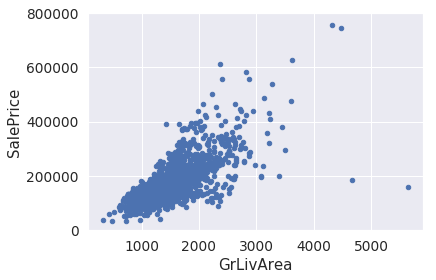

In [53]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

What has been revealed:

* The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. We can speculate why this is happening. Maybe they refer to agricultural area and that could explain the low price. I'm not sure about this but I'm quite confident that these two points are not representative of the typical case. Therefore, we'll define them as outliers and delete them.
* The two observations in the top of the plot are those 7.something observations that we said we should be careful about. They look like two special cases, however they seem to be following the trend. For that reason, we will keep them.

In [54]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,...,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,...,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [0]:
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


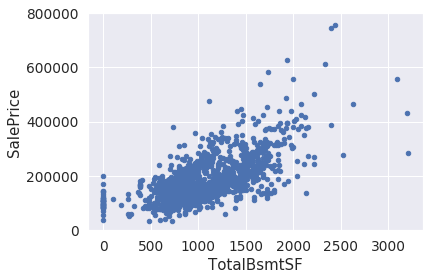

In [56]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

We can feel tempted to eliminate some observations (e.g. TotalBsmtSF > 3000) but I suppose it's not worth it. We can live with that, so we'll not do anything.

# In the search for normality
The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:

Histogram - Kurtosis and skewness.

Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.

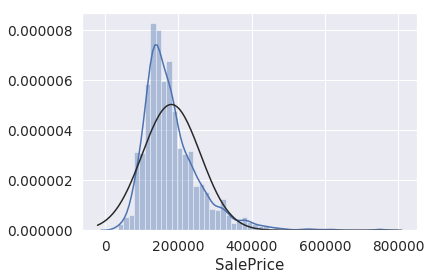

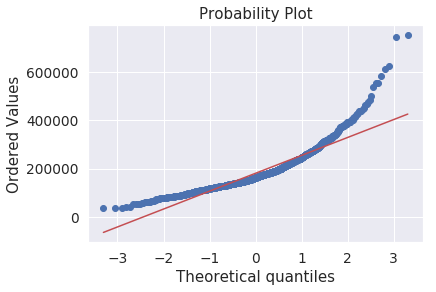

In [57]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [58]:
df_train[df_train.SalePrice <=0 ]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

In [0]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

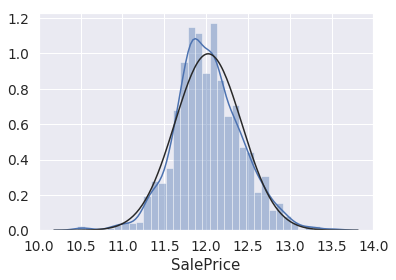

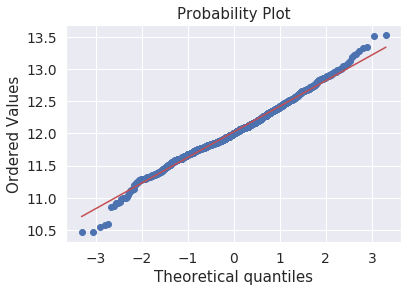

In [60]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Let's check what's going on with 'GrLivArea'.

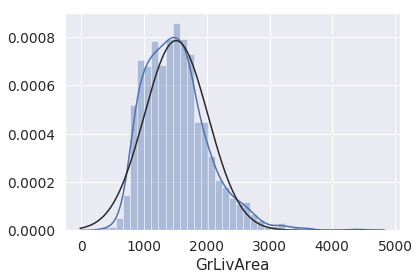

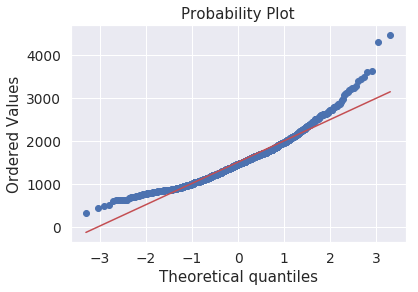

In [61]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

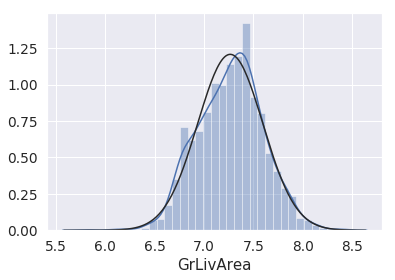

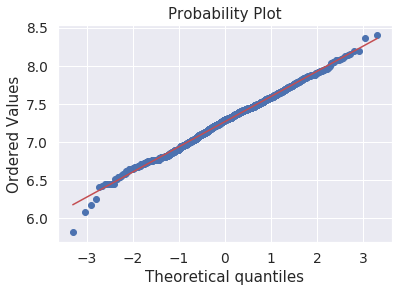

In [62]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

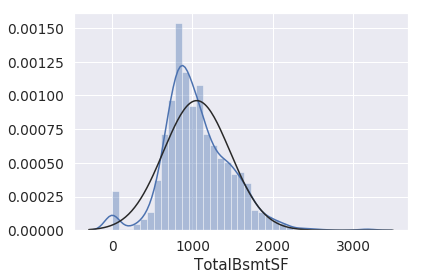

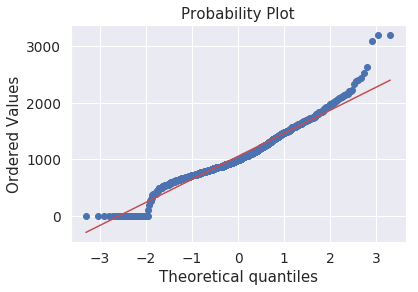

In [63]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

What do we have here?

Something that, in general, presents skewness.
A significant number of observations with value zero (houses without basement).
A big problem because the value zero doesn't allow us to do log transformations.
To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

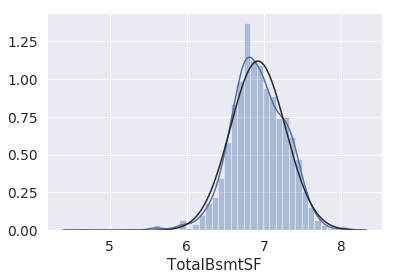

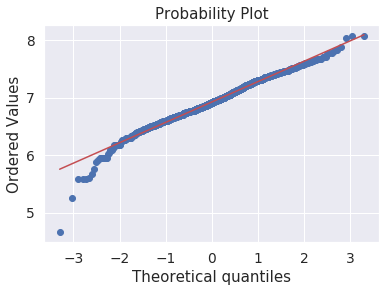

In [64]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

# In the search for writing 'homoscedasticity' right at the first attempt

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

Starting by 'SalePrice' and 'GrLivArea'...

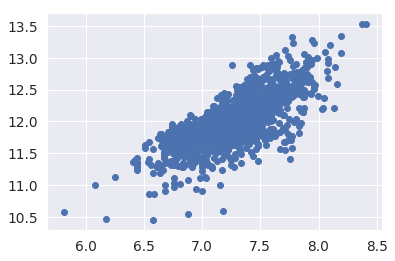

In [65]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

Older versions of this scatter plot (previous to log transformations), had a conic shape (go back and check 'Scatter plots between 'SalePrice' and correlated variables (move like Jagger style)'). As you can see, the current scatter plot doesn't have a conic shape anymore. That's the power of normality! Just by ensuring normality in some variables, we solved the homoscedasticity problem.

Now let's check 'SalePrice' with 'TotalBsmtSF'.

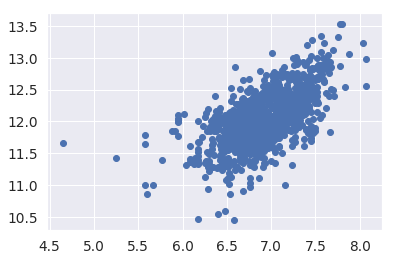

In [66]:
#scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

We can say that, in general, 'SalePrice' exhibit equal levels of variance across the range of 'TotalBsmtSF'. Cool!

# Dummy variables


In [0]:
#convert categorical variable into dummy
df_combined = pd.get_dummies(df_combined)

In [0]:
df_combined =df_combined.loc[:,~df_combined.columns.duplicated()]

# Categorical feature encoding

In [0]:
# def do_label_enc(df, col):
#     encoder = LabelEncoder()
#     df[col] = encoder.fit_transform(df[col].values)
#     return df

# def do_freq_enc(df, col):
#     traindf = df.iloc[0:train.shape[0]].copy()
#     freq_map = traindf[col].value_counts() / train.shape[0]
#     df.loc[:, col + "_freq"] = df[col].map(freq_map)
#     return df

In [70]:
df_combined.shape

(2917, 231)

In [71]:
df_train.shape

(1458, 82)

In [0]:
traindf = df_combined.iloc[0:df_train.shape[0]].copy()
traindf.loc[:, "target"] = np.log(df_train.SalePrice+1)
testdf = df_combined.iloc[df_train.shape[0]::].copy()

In [73]:
print("Train: ",traindf.shape)
print("Test: ",testdf.shape)

Train:  (1458, 232)
Test:  (1459, 231)


In [0]:
categorical_feature_indices = np.where(testdf.dtypes == "object")[0]
categorical_feature_indices

In [75]:
traindf, holddf = train_test_split(traindf, test_size=0.2, random_state=0)
print((traindf.shape, holddf.shape, testdf.shape))

x_hold = holddf.drop("target", axis=1)
y_hold = holddf.target
x_test = testdf

((1166, 232), (292, 232), (1459, 231))


# Helper methods

In [0]:
def run_catboost(traindf, testdt, holddf, cat_features, params, n_splits=10, n_repeats=1):
    n_splits=10

    feature_importance_df = pd.DataFrame(index=testdf.columns.values)
    folds = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    p_hold = np.zeros(holddf.shape[0])
    p_test = np.zeros(testdf.shape[0])

    m = 0
    cv_scores = []
    for train_idx, dev_idx in folds.split(traindf):
        x_train, x_dev = traindf.drop("target", axis=1).iloc[train_idx], traindf.drop("target", axis=1).iloc[dev_idx]
        y_train, y_dev = traindf.target.iloc[train_idx], traindf.target.iloc[dev_idx]

        train_pool = Pool(x_train, y_train, cat_features=cat_features)
        dev_pool = Pool(x_dev, y_dev, cat_features=cat_features)
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=dev_pool)

        # bagging predictions for test and hold out data:
        p_hold += model.predict(x_hold)/(n_splits*n_repeats)
        log_p_test = model.predict(x_test)
        p_test += (np.exp(log_p_test) - 1)/(n_splits*n_repeats)

        # predict for dev fold:
        y_pred = model.predict(x_dev)
        feature_importance_df.loc[:, "fold_" + str(m)] = model.get_feature_importance(train_pool)
        cv_scores.append(np.sqrt(mse(y_dev, y_pred)))
        m+=1

    print("hold out rmse: " + str(np.sqrt(mse(y_hold, p_hold))))
    print("cv mean rmse: " + str(np.mean(cv_scores)))
    print("cv std rmse: " + str(np.std(cv_scores)))
    
    feature_importance_df["mean"] = feature_importance_df.mean(axis=1)
    feature_importance_df["std"] = feature_importance_df.std(axis=1)
    feature_importance_df = feature_importance_df.sort_values(by="mean", ascending=False)
    
    plt.figure(figsize=(15,20))
    sns.barplot(x=feature_importance_df["mean"].values, y=feature_importance_df.index.values);
    plt.title("Feature importances");
    plt.show()
    
    results = {"last_model": model,
               "last_train_pool": train_pool,
               "feature_importance": feature_importance_df, 
               "p_hold": p_hold,
               "p_test": p_test}
    return results

In [0]:


#Model paramete
org_params = {
    'iterations': 1000,
    'learning_rate': 0.4871,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'loss_function': 'RMSE',
    'od_type': 'Iter',
    'od_wait': 200,
    'one_hot_max_size': 10,
    'l2_leaf_reg': 3,
    'depth': 2
}

In [80]:
results = run_catboost(traindf,
                       testdf,
                       holddf,
                       categorical_feature_indices,
                       org_params,
                       n_splits=10,
                       n_repeats=1)
p_hold = results["p_hold"]
p_test = results["p_test"]
feature_importance_df = results["feature_importance"]

CatBoostError: ignored

Insights
A lot of feature were not used by catboost and are not important for our task. You can see that many of them belong to those features that show only a few variation like LandContour, BsmtCond and GarageQual. This confirms our approach to drop such kind of features even more.

In [79]:
feature_importance_df.head(5)

NameError: ignored

Insights

* There is a lot of variation of the feature importance between folds! What does this mean?
* How useful a feature is to fit the training data depends on the data itself and how big the dataset is.
* If you increase the number of splits the most important features will change! Try it out!
Remember that our test dataset is the same size as the training dataset. It's very likely that we will overfit to our training data and that we will not be able to generalize well on the test data.
* What can we do to reduce this problem?
* We should drop features that almost have no importance!
* We should include randomness into allowed features that can be used by our model.
* We should include more randomess to our KFold as well (run it several times, make averaged predictions with each KFold)
* We should use different models that contribute to our prediction (besides complex ones that cover non-linear patters also some simple ones like linear models that are not that likely to overfit).
* We may like to enemble.

In [0]:
submission.loc[testdf.index.values, "SalePrice"] = p_test
submission = submission.reset_index()
submission.head()

In [0]:
submission.to_csv("submission_before_feature_selection.csv", index=False)
submission = submission.set_index("Id")
submission.head()

# Hyperparameter tuning

If you like you can use this code to tune hyperparameters of catboost. It randomly selects the hyperparameters and runs catboost with 10 fold cross-validation. The best model is picked by the median of the scores that are obtained on the dev-fold.

In [0]:
def hyperopt_objective(params):
    org_params.update(params) 
    org_params.update(logging_level='Silent')
    model = CatBoostRegressor(**org_params)
    
    cv_data = cv(
        Pool(traindf.drop("target", axis=1), traindf.target, cat_features=categorical_feature_indices),
        model.get_params(),
        fold_count=10
    )
    best_rmse = np.median(cv_data['test-RMSE-mean'])
    
    return best_rmse 

In [0]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 5, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

In [0]:
tune_hyparams = True
# num trials for hyperparameter tuning
num_evals = 15
if tune_hyparams:
    trials = hyperopt.Trials()

    best = hyperopt.fmin(
        hyperopt_objective,
        space=params_space,
        algo=hyperopt.tpe.suggest,
        max_evals=num_evals,
        trials=trials,
        rstate=RandomState(3)
    )

    print(best)
    org_params.update(best)

# Feature selection
Ok, first of all, let's drop the last 10 features of our sorted importances:

In [0]:
to_drop = feature_importance_df.iloc[-10:].index.values
df_combined = df_combined.drop(to_drop, axis=1)
to_drop

In [0]:
traindf = df_combined.iloc[0:df_train.shape[0]].copy()
traindf.loc[:, "target"] = np.log(df_train.SalePrice+1)
testdf = df_combined.iloc[df_train.shape[0]::].copy()

In [0]:
categorical_feature_indices = np.where(testdf.dtypes == "object")[0]
categorical_feature_indices

In [0]:
traindf, holddf = train_test_split(traindf, test_size=0.3, random_state=0)
print((traindf.shape, holddf.shape, testdf.shape))

x_hold = holddf.drop("target", axis=1)
y_hold = holddf.target
x_test = testdf

In [0]:
results = run_catboost(traindf,
                       testdf,
                       holddf,
                       categorical_feature_indices,
                       org_params,
                       n_splits=10,
                       n_repeats=1)
p_hold = results["p_hold"]
p_test = results["p_test"]
feature_importance_df = results["feature_importance"]

In [0]:
feature_importance_df.head(10)

In [0]:
submission.loc[testdf.index.values, "SalePrice"] = p_test
submission = submission.reset_index()
submission.head()

In [0]:
submission.to_csv("submission_feature_selection.csv", index=False)
submission = submission.set_index("Id")
submission.head()